# Stock Market Tweet Analysis


TODO:
- Collect data set from twitter
- Clean data set
- Classify a single tweet as bull/bear using Naive Bayes
- Classify a single tweet using deep learning model
- (maybe) Classify a single tweet across multiple classes. Bull/bear, good/bad, greedy/frugal, ...
- Classify all tweets of a given stock over time. Time series sentiment analysis
- Compare sentiment to price of stock. Make pretty graphs

https://www.geeksforgeeks.org/explanation-of-bert-model-nlp/
https://www.geeksforgeeks.org/sentiment-classification-using-bert/?ref=rp

https://medium.com/@aniruddha.choudhury94/part-2-bert-fine-tuning-tutorial-with-pytorch-for-text-classification-on-the-corpus-of-linguistic-18057ce330e1

https://www.youtube.com/watch?v=4Bdc55j80l8&ab_channel=TheA.I.Hacker-MichaelPhi

https://wandb.ai/pommedeterresautee/speed_training/reports/Train-HuggingFace-Models-Twice-As-Fast--VmlldzoxMDgzOTI


In [1]:
import torch
import re
import wget
import os
import time
import pandas as pd
import numpy as np
import random
import string
from tqdm import tqdm
from transformers import BertTokenizer, AutoTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup

# Configure GPU
if torch.cuda.is_available ():    
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print("CPU")
    device = torch.device("cpu")

GPU: TITAN Xp


## Abstract

The stock market is arguably the most competitive environment, and every trader and institution is trying to gain an edge in this algorithmic arms race. Even though algorithmic trading computers have taken over the trading floors and now account for the majority of trades on the stock market, human psychology plays an important role in the market's movements. Stock market data is widely available and used for trading, however there are massive quantities of qualitative text data that has great influence over the market. In this project, our goal is to collect a data set of stock tweets and train a model to quantify sentiment on a given opinion about the stock market.

## Methodology

What we're trying to do is classify a given tweet as either bullish or bearish.*Bullish* meaning they think the stock is going up, *bearish* meaning they it's going down. The type of problem we are trying to solve is text classification.


This project is comprised of 4 parts:
1. Collecting a data set and understanding potential bias
2. Loading, cleaning, and embedding data
3. Initializing the model
4. Training and Evaluating the model

# BERT Model

In this project, we are finetuning the robust BERT model. BERT is a transformer model developed by Google in 2018. To our benefit, the awesome people over at <a href="https://github.com/huggingface">Hugging Face</a> have made NLP a little bit easier for us. Their library allows us to download the BERT model and use it with PyTorch. They also have many handy utilities to encode our data for the model. We'll be finetuning the BERT model with one additional output layer which will provide us with the predicted classification.

In [ ]:
# model_name = "bert-based-cased"
# model_name = "bert-large-cased"
# model_name = "bert-based-uncased"
# model_name = "bert-large-uncased"
model_name = "ipuneetrathore/bert-base-cased-finetuned-finBERT"


# Collecting a data set

In order to collect a data set, we are using Stocktwits' API. Stocktwits is a wrapper on top of Twitter for stock market related information. Stocktwits allows for users to tweet on their platform and mark their opinion as either bullish or bearish on the stock.

Since it takes hours to scrape data, we scraped it ahead of time. Here's an example of fetching a single tweet from the API.

In [2]:
# insert API call here

### Unbiasing Data

The platform also allows users to embed *cashtags* which are like hashtags except for stock symbols. For example $AAPL would link to Apple's stock. However, this presents a problem, as a given stock could introduce a bias into the data.

Let's say a stock like Tesla is overwhelmingly bullish, then the model might weight the token "\\$TSLA" with extreme positivity. Then, a tweet such as "$TSLA is gonna crash!" might be classified as bullish by our model.

To prevent bias in our data, we are replacing each token that starts with the "\\$[A-z]" with "\<SYM\>". 

In [3]:
tweet = "$TSLA is gonna crash!"

re.sub("\$[A-z]*", "", tweet)

' is gonna crash!'

## Loading Data Set

In [21]:
# data cleaning
df = pd.read_csv("data/data.csv", delimiter=",", header=None)
df = df.rename(columns={0 : "tweet", 1 : "label"})

# drop short tweets
print(len(df))
short_tweets = []
for i in range(len(df["tweet"])):
    if len(re.sub("SYM", "", df["tweet"][i]).split(" ")) < 7:
        short_tweets.append(i)

df = df.drop(short_tweets)

print(len(df))
# only take unique values
df = df.drop_duplicates()
df["label"] = [1 if x == "Bullish" else 0 for x in df["label"]]
df ["tweet"] = [re.sub("SYM", "", tweet) for tweet in df["tweet"]]

#print(len(df))
#df.sample(10)

37532
27129


# Encoding Data for BERT

The model being used in this project is BERT.

- Add "[CLS]" at the beginning of each section and "[SEP]" at the end of every sentence
- lowercase each token
- Represent each token using an ID
- Pad or Truncate sequences to a fixed length
- 

BERT Tokenizer
https://huggingface.co/transformers/model_doc/bert.html?highlight=berttokenizer

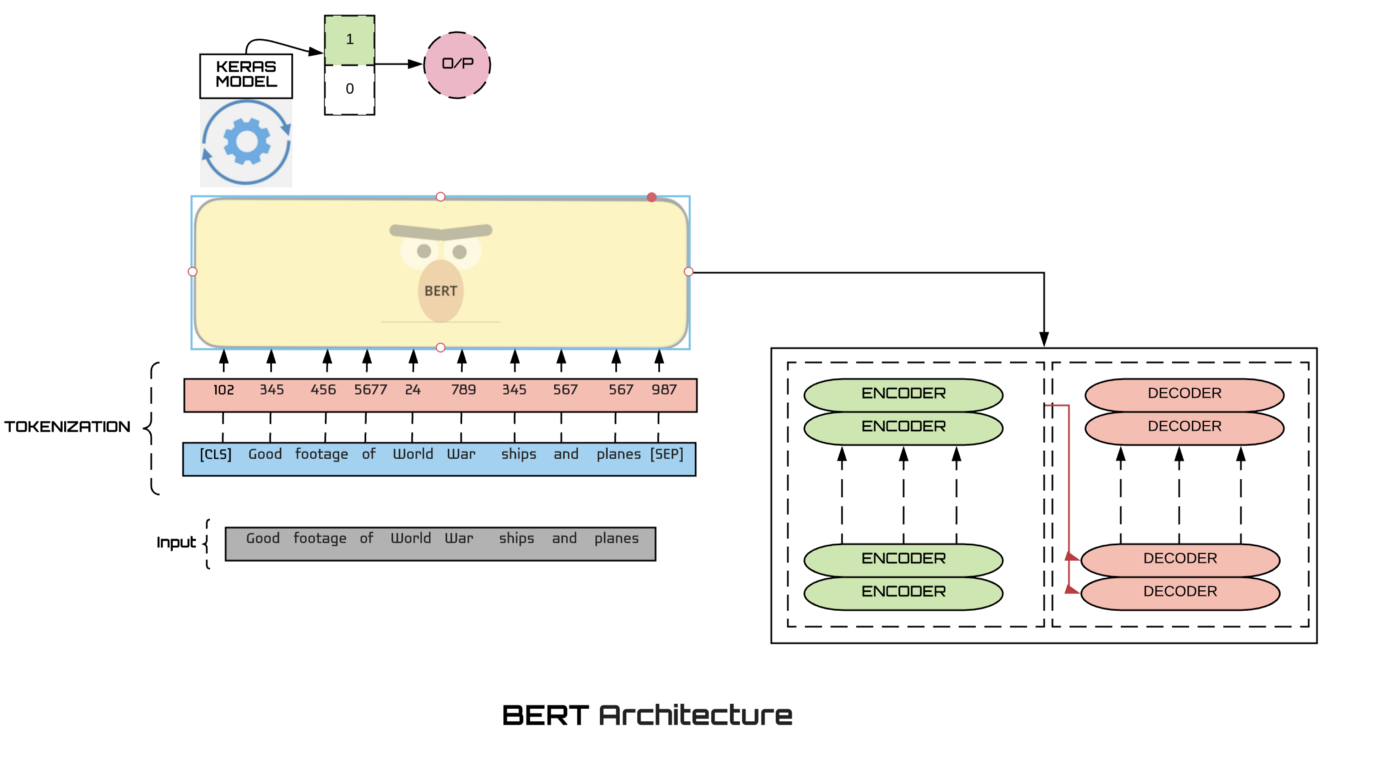

In [22]:
sentences = df.tweet.values
labels = df.label.values

In [23]:
# Load the BERT tokenizer.
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [24]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)
    
# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:   Im adding more every month up till the point this hits 50  after that I ll start working on my   and 
Token IDs: [101, 146, 1306, 5321, 1167, 1451, 2370, 1146, 6174, 1103, 1553, 1142, 4919, 1851, 1170, 1115, 146, 1325, 1838, 1684, 1113, 1139, 1105, 102]


In [25]:
# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 100
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")



Padding/truncating all sentences to 100 values...

Padding token: "[PAD]", ID: 0


In [26]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [27]:
# Use train_test_split to split our data into train and validation sets for
# training

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.2)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.2)

In [28]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [29]:

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.
batch_size = 32
# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [30]:
'''
model = BertForSequenceClassification.from_pretrained(
    "bert-based-cased",
    num_labels = 2, # Binary classification
    output_attentions = False,
    output_hidden_states = False,
)
'''
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
)

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 5

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [32]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [33]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
# Set the seed value all over the place to make this reproducible.

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

for epoch_i in tqdm(range(0, epochs)):
    
    # ========================================
    #               Training
    # ========================================
    
    # Reset the total loss for this epoch.
    total_loss = 0
    
    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
            
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()
        
        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update model parameters
        optimizer.step()
        
        # Update the scheduled learning rate.
        scheduler.step()
        
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    
        
    # ========================================
    #               Validation
    # ========================================
    model.eval()
    
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        
        with torch.no_grad():        
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
    # Report the final accuracy for this validation run.
    print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    
print("")
print("Training complete!")

 20%|██        | 1/5 [03:03<12:15, 183.76s/it]

Accuracy: 0.80


 40%|████      | 2/5 [06:08<09:11, 184.00s/it]

Accuracy: 0.81


 60%|██████    | 3/5 [09:13<06:08, 184.22s/it]

Accuracy: 0.81


 80%|████████  | 4/5 [12:17<03:04, 184.27s/it]

Accuracy: 0.81


100%|██████████| 5/5 [15:20<00:00, 184.14s/it]

Accuracy: 0.81

Training complete!


In [34]:
df = pd.read_csv("data/data.csv", delimiter=',', header=None, names=['tweet', 'label'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))
# Create sentence and label lists
sentences = df.tweet.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)
    
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)
    
# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 37,532



TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  logits = outputs[0]
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
print('DONE.')

In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

In [ ]:
from sklearn.metrics import matthews_corrcoef
matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
print('MCC: %.3f' % mcc)